In [1]:
import os
import sys
import seawater as sw
from scipy import interpolate as interp
from functools import partial 

sys.path.append("../scripts")
sys.path.append("../src/iw_model")
sys.path.append("../src/iw_inverse")
sys.path.append("../src/misc")

from iw_invert import InternalWaveInversion, model_matrix
from iw_plots import *
from extract import *
from pseudo_inverse import *
from COR.utils import *


In [2]:
#Load database
with open('llc_dz.npy','rb') as file:
    DZ = np.load(file)

with open('llc_n2z.npy','rb') as file:
    N2Z = np.load(file)
    
N2 = N2Z[1,:]
Z  = N2Z[0,:]

with open('llc_ax.npy','rb') as file:
    AX = np.load(file)

In [3]:
M2 = (1/12.42)*24
M4 = 2*M2

FREQS_SELECT = np.array([ M2,M4,0.046875, 0.09375,  0.140625, 1.5,
                         1.546875, 1.59375,  1.6875,
 1.734375, 1.78125,  1.828125, 1.875  ,  1.921875, 1.96875,  2.015625, 2.0625,
 2.109375, 2.15625,  2.203125, 2.25   ,  2.296875, 2.34375,  2.390625, 2.8125,
 2.859375, 2.90625,  2.953125, 3.     ,  3.046875, 3.46875,  3.515625, 3.5625,
 3.703125, 3.75   ,  3.796875, 3.84375,  3.890625, 3.9375 ,  3.984375, 4.0781,
 5.765625,])

DZB = digital_filter(DZ,FREQS_SELECT,1/24)
DZB=DZB.real


[161, 322, 4, 8, 12, 125, 129, 133, 141, 145, 148, 152, 156, 160, 164, 168, 172, 176, 180, 184, 187, 191, 195, 199, 234, 238, 242, 246, 250, 254, 289, 293, 297, 309, 312, 316, 320, 324, 328, 332, 340, 480]


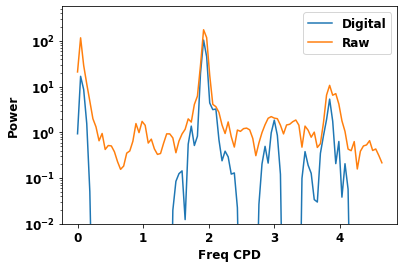

In [4]:
f,pxxf = sig.welch(DZB,fs=24,nperseg=512,axis=0)
plt.semilogy(f[:100],pxxf[:100,0,0,0],label='Digital')
f,pxx = sig.welch(DZ,fs=24,nperseg=512,axis=0)
plt.semilogy(f[:100],pxx[:100,0,0,0],label='Raw')
plt.xlabel('Freq CPD')
plt.ylabel('Power')
plt.ylim(1e-2,)
plt.plot(2,40)
plt.legend()

In [52]:
np.var(DZ)

600.2575949396866

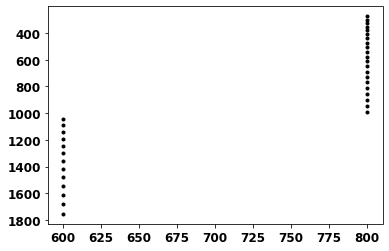

In [98]:
#Define sampling points
isl = (slice(200,416,1),slice(16,50,1),slice(0,12,1),slice(0,12,1))


#Compute depth variance then apply it to the dataset
#R = np.var(DZB, axis=(0,2,3))
#R = R[isl[1]]
Zr = AX[0,isl[1],0,0]["z"]
#snr = .5
#R = np.array([40- (1-snr)*r if (1-snr)*r > 1 else 1 for r in R])


#Define a depth variance profile
@np.vectorize
def step_func(z):
    if z > 1000:
        return 600
    else: 
        return 800

R =  step_func(Zr) #np.var(DZB,axis=(0,2,3))
RofZ = interp.interp1d(Zr,R)
plt.plot(R,Zr,'k.')
plt.gca().invert_yaxis()

In [81]:
"""
Contruct a set of parameters
"""
%load_ext autoreload
%autoreload

def rms(err_vec):
    return np.sqrt( (err_vec.T @ err_vec)/len(err_vec) )

#Parameters
FREQS = np.array(FREQS_SELECT)/(24*3600)
ANGLES  = np.arange(0,360,30)
MODES = np.arange(0,8)
print(FREQS)

#Data
isl = (slice(200,368,1),slice(16,50,1),slice(0,12,1),slice(0,12,1))

#Subsample data set create dataframe
cube = pd.DataFrame({"dz"    : DZ[isl].flatten(),
                     "time"  : AX[isl]["t"].flatten(),
                     "z"     : AX[isl]["z"].flatten(),
                     "x"     : AX[isl]["x"].flatten(),
                     "y"     : AX[isl]["y"].flatten()
                    })

cube['date'] = pd.to_datetime(cube['time'] + t0, unit='s')
cube['R'] = RofZ(cube['z'])
cube['RINV'] = 1/RofZ(cube['z'])

si = .8
split_time = (max(cube.time)-min(cube.time))*si + min(cube.time)
train= cube[cube.time < split_time]
test = cube[cube.time > split_time]

times = np.unique(train['time'])

#Create inversion model
iwi = InternalWaveInversion(train.loc[train['time']==times[0]],
                            FREQS,MODES,ANGLES,
                            Z_even,N2F(Z_even,),
                            tc='dz',mean=True)

iwi.ps['Q']    = 0.1/(iwi.ps['modes'] + 3)**2
iwi.ps['QINV'] = (iwi.ps['modes'] + 3)**2/1

ab = np.random.rand(2*len(iwi.ps))
Q = np.diag(np.concatenate([iwi.ps['Q'],iwi.ps['Q']]))
print(Q.shape)
"""
Compute RLS fit to Parameters
"""
Qs = []
Ls = []
Gs= []
li = 1
for it in tqdm(times):
    #Grab time slice
    ds = train.loc[train['time']==it]
    
    #Update H matrix & Predict
    H = model_matrix(ds,iwi.ps,iwi.iwmodes)
    est = H @ ab
    innovation =ds['dz'] - est
    
    #Correct & Update
    R = np.diag(ds['R'].values)
    INV = np.linalg.inv(li * H @ Q @ H.T + R)
    K = Q @ H.T @ INV
    ab = ab + K @ innovation
    Q = li*(Q - K @ H @ Q)
    
    #Compute conversion factor
    loss =  rms(innovation) 
    est = H @ ab
    gamma = rms( (ds['dz'] - est) )/loss
    Ls.append(loss)
    Gs.append(gamma)
    Qs.append(np.sum(np.diagonal(Q)) )
    print( "Loss %.2f" % np.sqrt(innovation.T@ innovation) )
    print( "Q %.2f" % np.sum(np.diagonal(Q)) )
    #print(K)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
[2.23653605e-05 4.47307211e-05 5.42534722e-07 1.08506944e-06
 1.62760417e-06 1.73611111e-05 1.79036458e-05 1.84461806e-05
 1.95312500e-05 2.00737847e-05 2.06163194e-05 2.11588542e-05
 2.17013889e-05 2.22439236e-05 2.27864583e-05 2.33289931e-05
 2.38715278e-05 2.44140625e-05 2.49565972e-05 2.54991319e-05
 2.60416667e-05 2.65842014e-05 2.71267361e-05 2.76692708e-05
 3.25520833e-05 3.30946181e-05 3.36371528e-05 3.41796875e-05
 3.47222222e-05 3.52647569e-05 4.01475694e-05 4.06901042e-05
 4.12326389e-05 4.28602431e-05 4.34027778e-05 4.39453125e-05
 4.44878472e-05 4.50303819e-05 4.55729167e-05 4.61154514e-05
 4.72002315e-05 6.67317708e-05]
solving qg
solving qg
solving qg




  0%|          | 0/134 [00:00<?, ?it/s]

(8066, 8066)




  1%|          | 1/134 [00:39<1:28:15, 39.82s/it]

Loss 2831.64
Q 30.15




  1%|▏         | 2/134 [01:27<1:32:41, 42.13s/it]

Loss 967.67
Q 30.07




  2%|▏         | 3/134 [02:14<1:35:22, 43.69s/it]

Loss 1229.06
Q 30.02




  3%|▎         | 4/134 [03:01<1:37:00, 44.78s/it]

Loss 1401.51
Q 29.97




  4%|▎         | 5/134 [03:47<1:36:46, 45.01s/it]

Loss 1280.08
Q 29.92




  4%|▍         | 6/134 [04:34<1:37:03, 45.49s/it]

Loss 1019.85
Q 29.87




  5%|▌         | 7/134 [05:21<1:37:23, 46.01s/it]

Loss 1112.18
Q 29.82




  6%|▌         | 8/134 [06:06<1:36:22, 45.89s/it]

Loss 1133.79
Q 29.78




  7%|▋         | 9/134 [06:53<1:36:01, 46.09s/it]

Loss 1165.13
Q 29.73




  7%|▋         | 10/134 [07:43<1:37:51, 47.35s/it]

Loss 1132.06
Q 29.69




  8%|▊         | 11/134 [08:38<1:41:19, 49.43s/it]

Loss 968.89
Q 29.64




  9%|▉         | 12/134 [09:28<1:41:08, 49.74s/it]

Loss 1017.37
Q 29.60




 10%|▉         | 13/134 [10:15<1:38:51, 49.02s/it]

Loss 994.26
Q 29.56




 10%|█         | 14/134 [11:04<1:38:01, 49.01s/it]

Loss 1004.18
Q 29.52




 11%|█         | 15/134 [11:52<1:36:12, 48.50s/it]

Loss 1021.31
Q 29.48




 12%|█▏        | 16/134 [12:38<1:33:56, 47.77s/it]

Loss 1100.54
Q 29.45




 13%|█▎        | 17/134 [13:28<1:34:45, 48.59s/it]

Loss 1089.40
Q 29.41




 13%|█▎        | 18/134 [14:18<1:34:29, 48.87s/it]

Loss 949.09
Q 29.38




 14%|█▍        | 19/134 [15:06<1:33:28, 48.77s/it]

Loss 888.43
Q 29.34




 15%|█▍        | 20/134 [15:58<1:34:30, 49.74s/it]

Loss 1067.74
Q 29.31




 16%|█▌        | 21/134 [16:45<1:32:02, 48.87s/it]

Loss 1120.19
Q 29.27




 16%|█▋        | 22/134 [17:34<1:31:00, 48.75s/it]

Loss 933.61
Q 29.24




 17%|█▋        | 23/134 [18:27<1:32:47, 50.16s/it]

Loss 816.15
Q 29.21




 18%|█▊        | 24/134 [19:23<1:35:19, 51.99s/it]

Loss 1178.38
Q 29.17




 19%|█▊        | 25/134 [20:11<1:32:16, 50.79s/it]

Loss 1043.05
Q 29.14




 19%|█▉        | 26/134 [20:59<1:29:50, 49.92s/it]

Loss 775.90
Q 29.11




 20%|██        | 27/134 [21:46<1:27:25, 49.02s/it]

Loss 664.77
Q 29.08




 21%|██        | 28/134 [22:35<1:26:16, 48.83s/it]

Loss 870.85
Q 29.05




 22%|██▏       | 29/134 [23:23<1:25:02, 48.59s/it]

Loss 967.56
Q 29.01




 22%|██▏       | 30/134 [24:13<1:25:24, 49.27s/it]

Loss 825.42
Q 28.98




 23%|██▎       | 31/134 [25:01<1:23:50, 48.84s/it]

Loss 663.23
Q 28.95




 24%|██▍       | 32/134 [25:48<1:21:45, 48.09s/it]

Loss 902.12
Q 28.92




 25%|██▍       | 33/134 [26:33<1:19:29, 47.22s/it]

Loss 1121.28
Q 28.89




 25%|██▌       | 34/134 [27:21<1:19:02, 47.43s/it]

Loss 880.97
Q 28.86




 26%|██▌       | 35/134 [28:29<1:28:33, 53.67s/it]

Loss 762.79
Q 28.83




 27%|██▋       | 36/134 [29:24<1:28:22, 54.11s/it]

Loss 865.79
Q 28.80




 28%|██▊       | 37/134 [30:12<1:24:33, 52.30s/it]

Loss 1019.11
Q 28.77




 28%|██▊       | 38/134 [30:58<1:20:41, 50.43s/it]

Loss 807.55
Q 28.74




 29%|██▉       | 39/134 [31:44<1:17:25, 48.90s/it]

Loss 812.44
Q 28.71




 30%|██▉       | 40/134 [32:31<1:16:06, 48.58s/it]

Loss 1014.00
Q 28.68




 31%|███       | 41/134 [33:18<1:14:19, 47.95s/it]

Loss 997.36
Q 28.66




 31%|███▏      | 42/134 [34:05<1:13:15, 47.78s/it]

Loss 800.32
Q 28.63




 32%|███▏      | 43/134 [34:54<1:12:54, 48.07s/it]

Loss 696.31
Q 28.60




 33%|███▎      | 44/134 [35:44<1:12:51, 48.57s/it]

Loss 935.73
Q 28.57




 34%|███▎      | 45/134 [36:33<1:12:33, 48.91s/it]

Loss 1041.96
Q 28.54




 34%|███▍      | 46/134 [37:26<1:13:25, 50.07s/it]

Loss 716.83
Q 28.51




 35%|███▌      | 47/134 [38:13<1:11:03, 49.00s/it]

Loss 818.88
Q 28.49




 36%|███▌      | 48/134 [39:00<1:09:41, 48.62s/it]

Loss 965.21
Q 28.46




 37%|███▋      | 49/134 [39:47<1:07:49, 47.87s/it]

Loss 814.56
Q 28.43




 37%|███▋      | 50/134 [40:33<1:06:27, 47.47s/it]

Loss 773.18
Q 28.40




 38%|███▊      | 51/134 [41:21<1:05:42, 47.50s/it]

Loss 865.26
Q 28.37




 39%|███▉      | 52/134 [42:09<1:05:05, 47.63s/it]

Loss 919.95
Q 28.35




 40%|███▉      | 53/134 [42:55<1:03:52, 47.32s/it]

Loss 812.26
Q 28.32




 40%|████      | 54/134 [43:42<1:02:42, 47.03s/it]

Loss 762.80
Q 28.29




 41%|████      | 55/134 [44:28<1:01:50, 46.97s/it]

Loss 854.72
Q 28.26




 42%|████▏     | 56/134 [45:15<1:00:47, 46.76s/it]

Loss 884.48
Q 28.24




 43%|████▎     | 57/134 [46:01<59:51, 46.65s/it]  

Loss 1000.60
Q 28.21




 43%|████▎     | 58/134 [46:48<59:00, 46.58s/it]

Loss 800.39
Q 28.18




 44%|████▍     | 59/134 [47:34<58:01, 46.42s/it]

Loss 650.96
Q 28.15




 45%|████▍     | 60/134 [48:20<57:23, 46.54s/it]

Loss 888.08
Q 28.13




 46%|████▌     | 61/134 [49:09<57:18, 47.11s/it]

Loss 909.19
Q 28.10




 46%|████▋     | 62/134 [49:56<56:23, 46.99s/it]

Loss 786.84
Q 28.07




 47%|████▋     | 63/134 [50:43<55:39, 47.04s/it]

Loss 800.09
Q 28.05




 48%|████▊     | 64/134 [51:31<55:15, 47.36s/it]

Loss 845.59
Q 28.02




 49%|████▊     | 65/134 [52:18<54:22, 47.28s/it]

Loss 856.51
Q 27.99




 49%|████▉     | 66/134 [53:06<53:44, 47.42s/it]

Loss 845.59
Q 27.97




 50%|█████     | 67/134 [53:52<52:42, 47.20s/it]

Loss 844.45
Q 27.94




 51%|█████     | 68/134 [54:39<51:44, 47.04s/it]

Loss 873.47
Q 27.92




 51%|█████▏    | 69/134 [55:29<51:58, 47.98s/it]

Loss 945.89
Q 27.89




 52%|█████▏    | 70/134 [56:17<51:06, 47.91s/it]

Loss 906.99
Q 27.86




 53%|█████▎    | 71/134 [57:05<50:17, 47.90s/it]

Loss 877.88
Q 27.84




 54%|█████▎    | 72/134 [57:52<49:18, 47.71s/it]

Loss 943.93
Q 27.81




 54%|█████▍    | 73/134 [58:43<49:23, 48.58s/it]

Loss 962.35
Q 27.79




 55%|█████▌    | 74/134 [59:28<47:34, 47.57s/it]

Loss 930.35
Q 27.76




 56%|█████▌    | 75/134 [1:00:12<45:46, 46.55s/it]

Loss 643.46
Q 27.74




 57%|█████▋    | 76/134 [1:01:02<45:53, 47.47s/it]

Loss 720.13
Q 27.71




 57%|█████▋    | 77/134 [1:01:50<45:19, 47.70s/it]

Loss 869.09
Q 27.69




 58%|█████▊    | 78/134 [1:02:37<44:18, 47.47s/it]

Loss 854.99
Q 27.66




 59%|█████▉    | 79/134 [1:03:22<42:59, 46.90s/it]

Loss 731.97
Q 27.64




 60%|█████▉    | 80/134 [1:04:08<41:51, 46.51s/it]

Loss 910.93
Q 27.61




 60%|██████    | 81/134 [1:04:53<40:41, 46.06s/it]

Loss 944.91
Q 27.59




 61%|██████    | 82/134 [1:05:42<40:44, 47.02s/it]

Loss 708.15
Q 27.56




 62%|██████▏   | 83/134 [1:06:30<40:08, 47.23s/it]

Loss 780.52
Q 27.54




 63%|██████▎   | 84/134 [1:07:17<39:25, 47.31s/it]

Loss 886.01
Q 27.52




 63%|██████▎   | 85/134 [1:08:06<38:56, 47.68s/it]

Loss 863.71
Q 27.49




 64%|██████▍   | 86/134 [1:08:52<37:49, 47.27s/it]

Loss 881.07
Q 27.47




 65%|██████▍   | 87/134 [1:09:41<37:16, 47.59s/it]

Loss 820.40
Q 27.44




 66%|██████▌   | 88/134 [1:10:29<36:41, 47.87s/it]

Loss 887.35
Q 27.42




 66%|██████▋   | 89/134 [1:11:19<36:18, 48.40s/it]

Loss 994.77
Q 27.39




 67%|██████▋   | 90/134 [1:12:08<35:42, 48.70s/it]

Loss 855.94
Q 27.37




 68%|██████▊   | 91/134 [1:12:59<35:25, 49.43s/it]

Loss 702.54
Q 27.35




 69%|██████▊   | 92/134 [1:13:51<34:58, 49.96s/it]

Loss 738.31
Q 27.32




 69%|██████▉   | 93/134 [1:14:41<34:13, 50.08s/it]

Loss 980.02
Q 27.30




 70%|███████   | 94/134 [1:15:32<33:29, 50.24s/it]

Loss 874.82
Q 27.27




 71%|███████   | 95/134 [1:16:16<31:32, 48.53s/it]

Loss 669.48
Q 27.25




 72%|███████▏  | 96/134 [1:17:01<30:00, 47.38s/it]

Loss 870.69
Q 27.22




 72%|███████▏  | 97/134 [1:17:46<28:53, 46.84s/it]

Loss 848.38
Q 27.20




 73%|███████▎  | 98/134 [1:18:37<28:42, 47.86s/it]

Loss 804.02
Q 27.18




 74%|███████▍  | 99/134 [1:19:26<28:07, 48.22s/it]

Loss 763.95
Q 27.15




 75%|███████▍  | 100/134 [1:20:16<27:40, 48.85s/it]

Loss 810.35
Q 27.13




 75%|███████▌  | 101/134 [1:21:05<26:50, 48.82s/it]

Loss 833.40
Q 27.10




 76%|███████▌  | 102/134 [1:21:51<25:41, 48.17s/it]

Loss 696.79
Q 27.08




 77%|███████▋  | 103/134 [1:22:40<24:53, 48.17s/it]

Loss 705.87
Q 27.06




 78%|███████▊  | 104/134 [1:23:37<25:28, 50.97s/it]

Loss 724.08
Q 27.03




 78%|███████▊  | 105/134 [1:24:33<25:19, 52.39s/it]

Loss 743.51
Q 27.01




 79%|███████▉  | 106/134 [1:25:32<25:25, 54.47s/it]

Loss 780.27
Q 26.99




 80%|███████▉  | 107/134 [1:26:25<24:19, 54.07s/it]

Loss 682.66
Q 26.96




 81%|████████  | 108/134 [1:27:20<23:32, 54.31s/it]

Loss 761.51
Q 26.94




 81%|████████▏ | 109/134 [1:28:20<23:19, 55.97s/it]

Loss 894.97
Q 26.91




 82%|████████▏ | 110/134 [1:29:21<22:59, 57.48s/it]

Loss 787.82
Q 26.89




 83%|████████▎ | 111/134 [1:30:23<22:32, 58.82s/it]

Loss 845.60
Q 26.87




 84%|████████▎ | 112/134 [1:31:16<20:54, 57.03s/it]

Loss 962.17
Q 26.84




 84%|████████▍ | 113/134 [1:32:04<19:01, 54.34s/it]

Loss 906.08
Q 26.82




 85%|████████▌ | 114/134 [1:32:52<17:31, 52.55s/it]

Loss 807.15
Q 26.80




 86%|████████▌ | 115/134 [1:33:41<16:18, 51.49s/it]

Loss 846.93
Q 26.78




 87%|████████▋ | 116/134 [1:34:30<15:12, 50.67s/it]

Loss 699.42
Q 26.75




 87%|████████▋ | 117/134 [1:35:17<14:02, 49.57s/it]

Loss 696.87
Q 26.73




 88%|████████▊ | 118/134 [1:36:06<13:09, 49.34s/it]

Loss 859.33
Q 26.71




 89%|████████▉ | 119/134 [1:36:54<12:15, 49.06s/it]

Loss 814.28
Q 26.68




 90%|████████▉ | 120/134 [1:37:42<11:21, 48.67s/it]

Loss 688.26
Q 26.66




 90%|█████████ | 121/134 [1:38:29<10:27, 48.25s/it]

Loss 694.86
Q 26.64




 91%|█████████ | 122/134 [1:39:14<09:26, 47.24s/it]

Loss 751.10
Q 26.61




 92%|█████████▏| 123/134 [1:40:04<08:47, 48.00s/it]

Loss 694.77
Q 26.59




 93%|█████████▎| 124/134 [1:40:50<07:55, 47.53s/it]

Loss 722.79
Q 26.57




 93%|█████████▎| 125/134 [1:41:40<07:12, 48.11s/it]

Loss 756.92
Q 26.55




 94%|█████████▍| 126/134 [1:42:27<06:22, 47.80s/it]

Loss 727.74
Q 26.52




 95%|█████████▍| 127/134 [1:43:14<05:32, 47.57s/it]

Loss 699.32
Q 26.50




 96%|█████████▌| 128/134 [1:44:02<04:45, 47.65s/it]

Loss 681.56
Q 26.48




 96%|█████████▋| 129/134 [1:44:48<03:56, 47.26s/it]

Loss 691.55
Q 26.45




 97%|█████████▋| 130/134 [1:45:35<03:08, 47.12s/it]

Loss 719.38
Q 26.43




 98%|█████████▊| 131/134 [1:46:24<02:22, 47.65s/it]

Loss 824.22
Q 26.41




 99%|█████████▊| 132/134 [1:47:11<01:34, 47.46s/it]

Loss 774.00
Q 26.39




 99%|█████████▉| 133/134 [1:48:00<00:48, 48.11s/it]

Loss 759.91
Q 26.36




100%|██████████| 134/134 [1:48:47<00:00, 48.72s/it]

Loss 762.40
Q 26.34


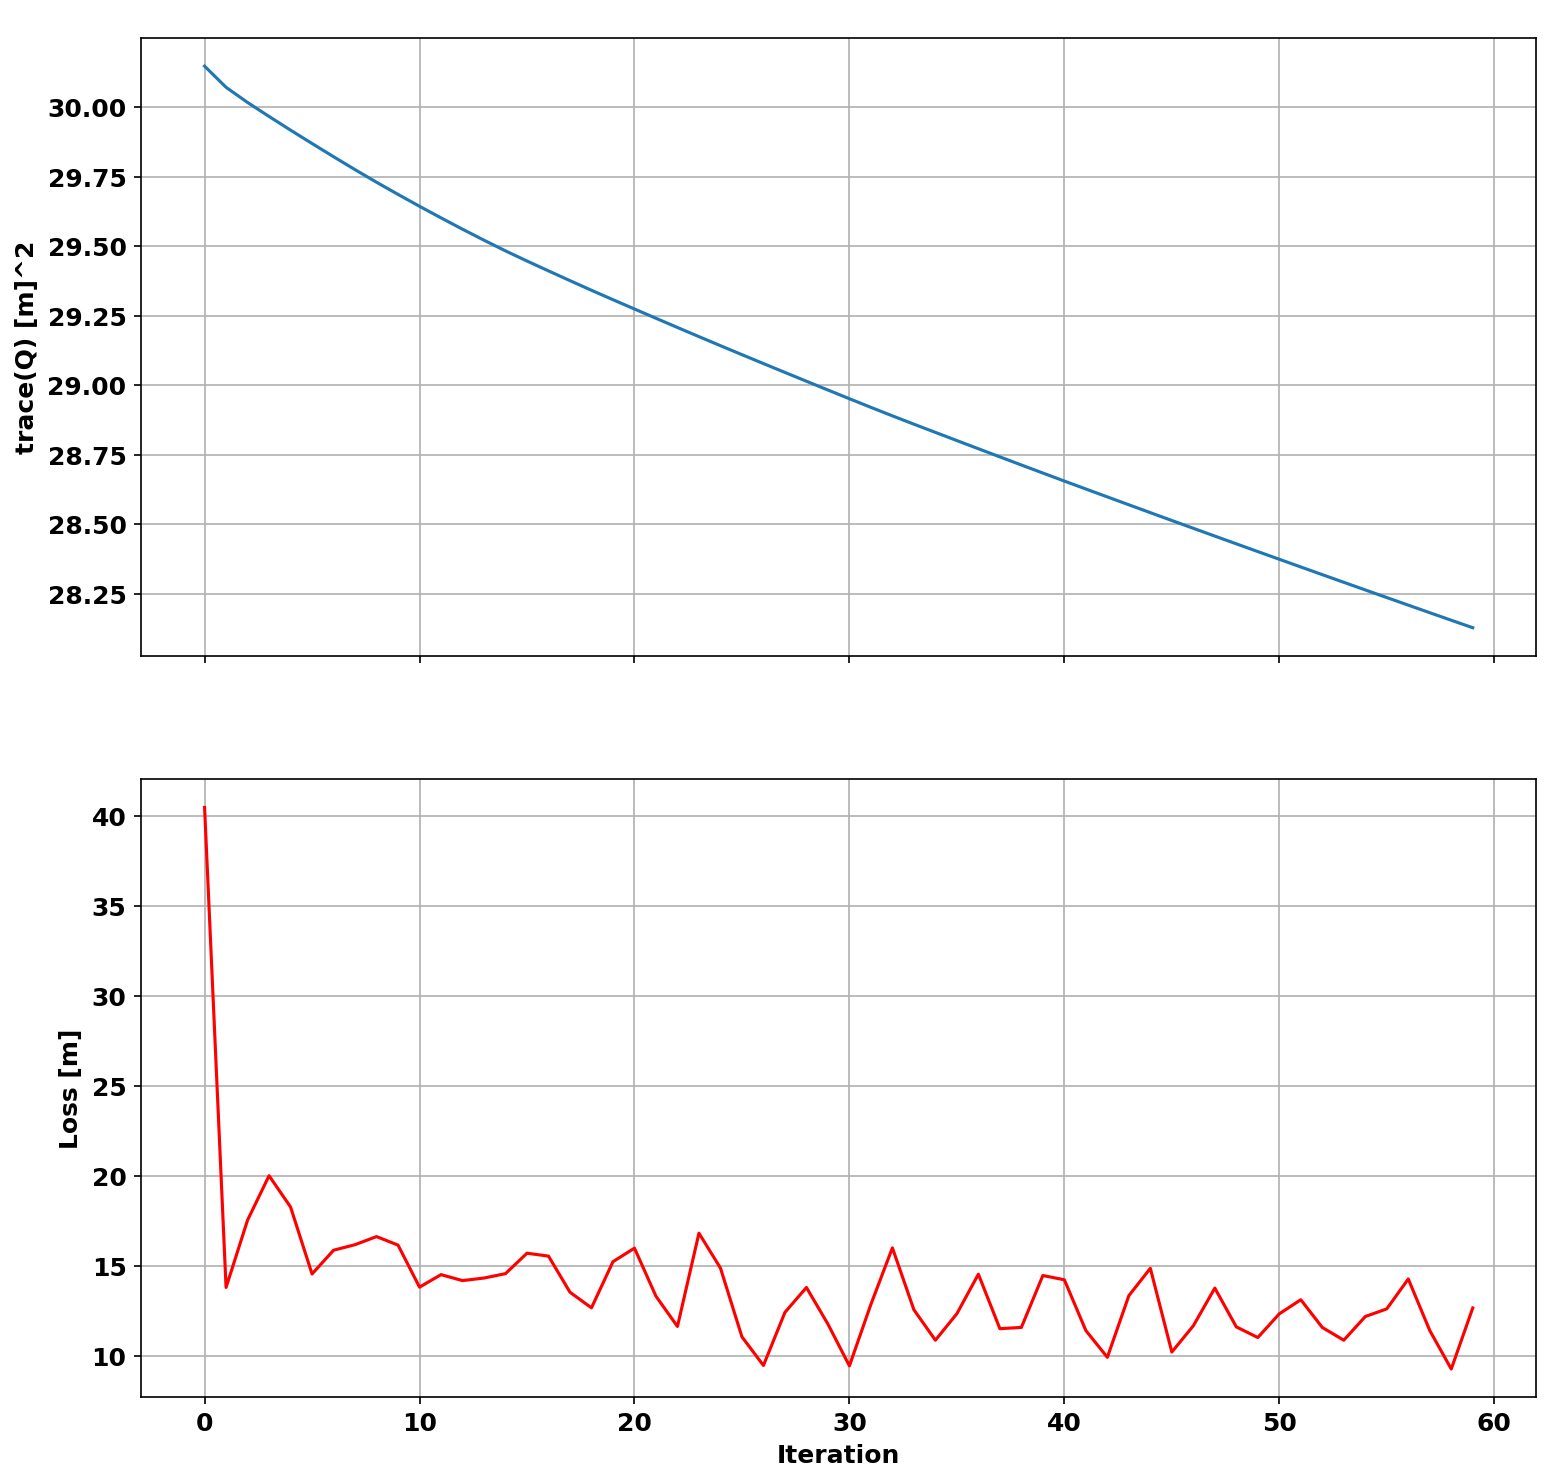

In [82]:
f,ax =plt.subplots(2,1,sharex=True)
ax[0].plot(Qs[0:60],label='Trace of Error Covariance')
ax[1].plot(Ls[0:60],'r',label='Loss')
ax[1].set_ylabel('Loss [m]')
ax[0].set_ylabel('trace(Q) [m]^2')
ax[1].set_xlabel('Iteration')
ax[0].grid(True)
ax[1].grid(True)
f.legend(bbox_to_anchor=(.9, 0.9))
f.set_size_inches(12,12)
f.set_dpi(150)

In [83]:
#Update param space
l = len(iwi.ps)
#diffa = iwi.ps['a']-ab[:l]
#diffb = iwi.ps['b']-ab[l:]
iwi.ps['a'] = ab[:l]
iwi.ps['b'] = ab[l:]
iwi.ps.head()

,freqs,hwvn,modes,theta,Q,QINV,a,b
0,0.000000,0.000000+0.000000j,0,0.0,0.011111,9.0,0.367876,2.069767
1,0.000022,0.000008+0.000000j,0,0.0,0.011111,9.0,0.600718,0.732851
2,0.000022,0.000008+0.000000j,0,30.0,0.011111,9.0,0.545309,0.560434
3,0.000022,0.000008+0.000000j,0,60.0,0.011111,9.0,1.057708,0.563177
4,0.000022,0.000008+0.000000j,0,90.0,0.011111,9.0,0.555041,1.263287


In [84]:
#w,v = np.linalg.eig(Q)
#vp = v[:,np.argsort(w)[::-1]]
#x = np.arange(0,360,5)
#plt.plot(x,vp[:72,0],'b.')
#plt.plot(x,vp[72:144,1],'r.')
#plt.plot(x,vp[144:216,1],'g.')
#plt.grid(True)

In [85]:
#Compute an estimate entire cube
%autoreload
delta = int(1e4)
j = delta
cube['dz_hat'] = 0
for i in np.arange(0,len(cube),delta):
    cube.loc[i:j,['dz_hat']] = iwi.estimate(ds=cube.loc[i:j])
    j= j + delta

cube['err']    = cube['dz_hat'] - cube['dz']


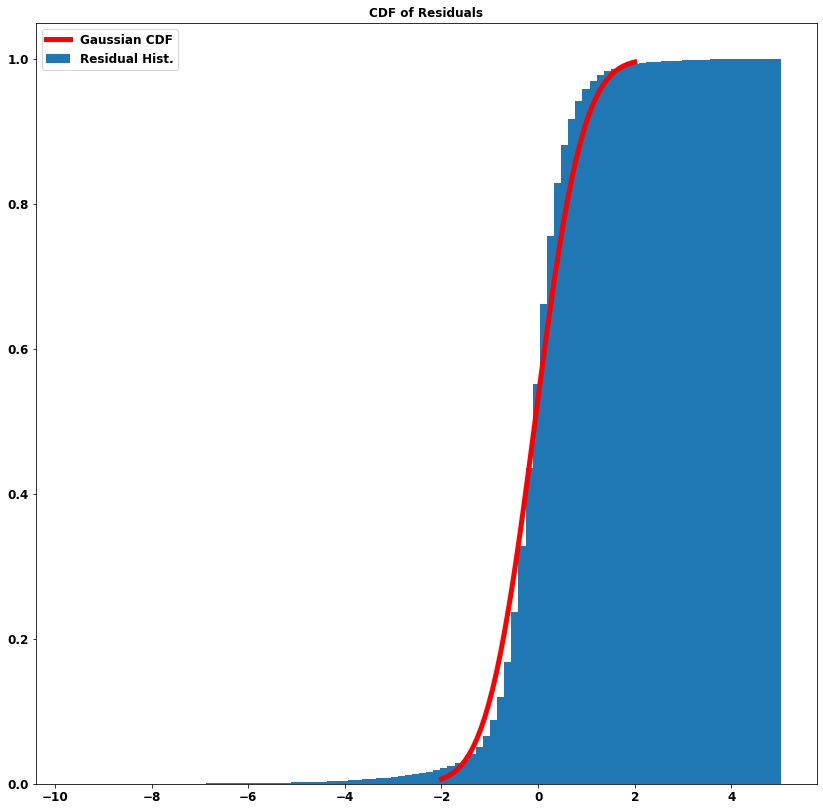

In [86]:
from scipy import stats
f , ax =plt.subplots()
x = np.linspace(-2,2)
errors = cube['err']/np.sqrt(RofZ(cube['z']))
h = ax.hist(errors,bins=100,density=True,cumulative=True,label='Residual Hist.')
ax.plot(x,stats.norm.cdf(x,np.mean(errors),np.sqrt(np.var(errors))),'r',linewidth=5,label='Gaussian CDF')
ax.set_title('CDF of Residuals')
ax.legend()
f.set_size_inches(14,14)

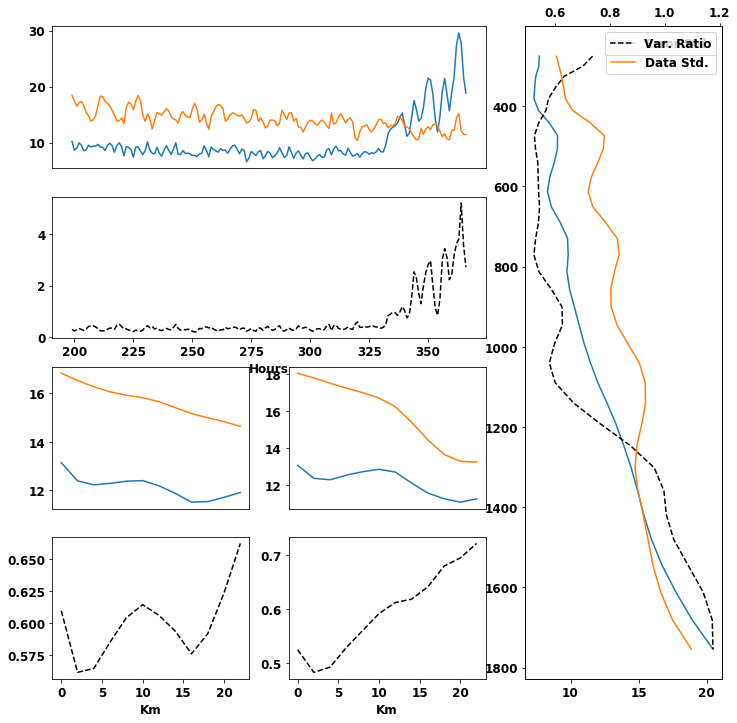

In [97]:
"""
Plot error variance across each exis
"""
%autoreload

DZH = cube['dz_hat'].values.reshape(DZ[isl].shape)
ERR = (DZH-DZ[isl])
VAL = DZ[isl]

f=plt.figure()
plot_error_variance(f,ERR,VAL,AX,isl)
f.set_size_inches(12,12)

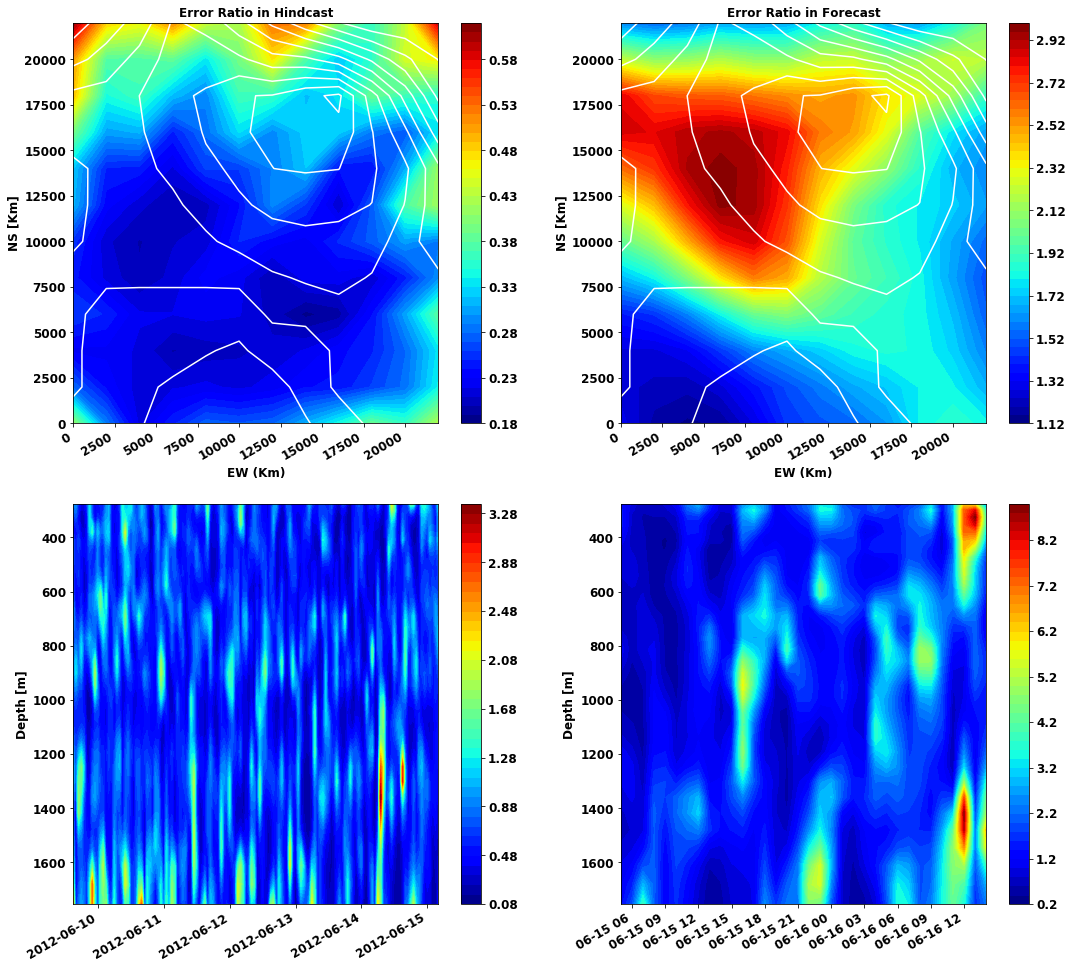

In [88]:
%autoreload
train= cube[cube.time < split_time]
test = cube[cube.time > split_time]

#Error ratio lat lon
latlon_test = test.groupby(['x','y']).var().reset_index()
latlon_test['r'] = (latlon_test['err']/latlon_test['dz'])


#Error ratio lat lon
latlon_train = train.groupby(['x','y']).var().reset_index()
latlon_train['r'] = (latlon_train['err']/latlon_train['dz'])

#Error ratio depth
depthtime_test = test.groupby(['date','z']).var().reset_index()
depthtime_test['r'] = (depthtime_test['err']/depthtime_test['dz'])

#Error ratio depth
depthtime_train = train.groupby(['date','z']).var().reset_index()
depthtime_train['r'] = (depthtime_train['err']/depthtime_train['dz'])


f,ax=plt.subplots(2,2)
p1 = plot_dataframe_slice(latlon_train,'x','y','r',ax[0,0],cmap='jet',levels=50)
ax[0,0].contour(X,Y,depth,levels=10,colors='w')
ax[0,1].contour(X,Y,depth,levels=10,colors='w')
p2 = plot_dataframe_slice(latlon_test,'x','y','r',ax[0,1],cmap='jet',levels=50)
p3 = plot_dataframe_slice(depthtime_train,'date','z','r',ax[1,0],cmap='jet',levels=50)
p4 = plot_dataframe_slice(depthtime_test,'date','z','r',ax[1,1],cmap='jet',levels=50)



ax[1,0].invert_yaxis()
ax[1,1].invert_yaxis()
ax[0,0].set_title('Error Ratio in Hindcast')
ax[0,1].set_title('Error Ratio in Forecast')
ax[0,0].set_ylabel('NS [Km]')
ax[0,1].set_ylabel('NS [Km]')
ax[0,1].set_xlabel('EW (Km)')
ax[0,0].set_xlabel('EW (Km)')
ax[1,0].set_ylabel('Depth [m]')
ax[1,1].set_ylabel('Depth [m]')

f.colorbar(p1,ax=ax[0,0])
f.colorbar(p2,ax=ax[0,1])
f.colorbar(p3,ax=ax[1,0])
f.colorbar(p4,ax=ax[1,1])
f.autofmt_xdate()
f.set_size_inches(18,18)

../src/misc/iw_plots.py:218: FutureWarning: `real` is deprecated and will be removed in a future version. To eliminate this warning for a Series `ser`, use `np.real(ser.to_numpy())` or `ser.to_numpy().real`.
  KX = 1000*psn['hwvn'].real*np.cos(2*np.pi*psn['theta']/360)
../src/misc/iw_plots.py:219: FutureWarning: `real` is deprecated and will be removed in a future version. To eliminate this warning for a Series `ser`, use `np.real(ser.to_numpy())` or `ser.to_numpy().real`.
  KY = 1000*psn['hwvn'].real*np.sin(2*np.pi*psn['theta']/360)


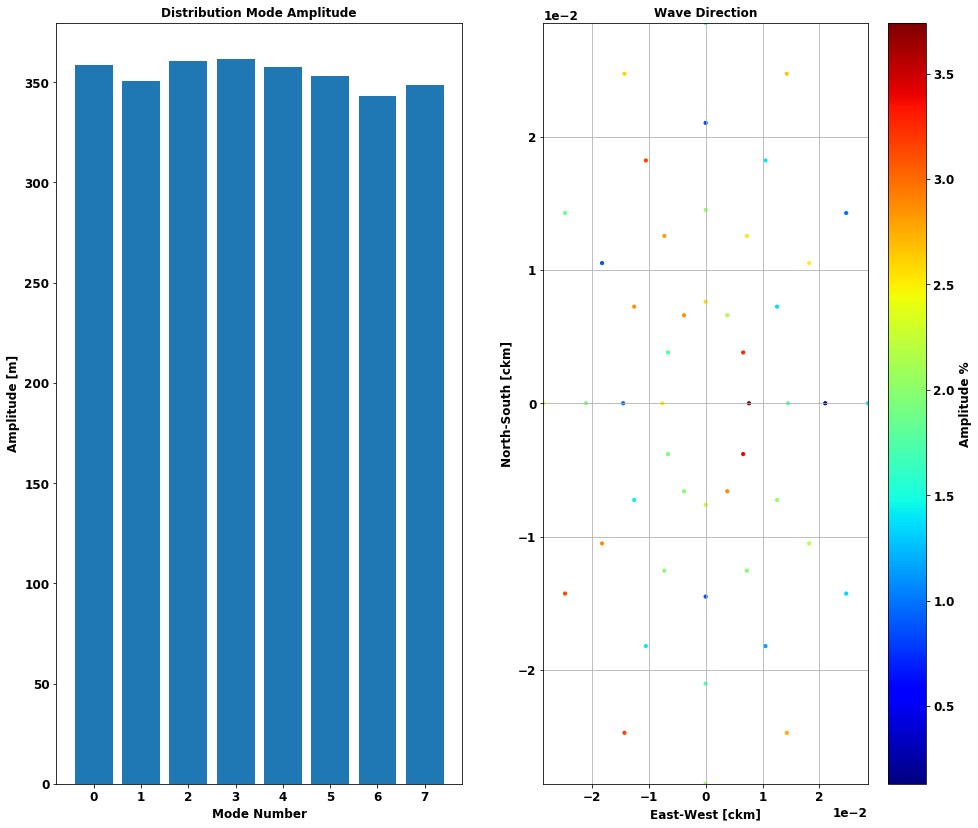

In [89]:
"""
Plotting Parameter space
"""
f,(ax1,ax2) =plt.subplots(1,2)
from iw_plots import *
%autoreload
mode_amplitude(ax1,iwi.ps)
p = k_space_magnitude(ax2,iwi.ps,4,1)
R1 = 1/130
t = np.linspace(0,2*np.pi)
#ax2.plot(R1*np.cos(t),R1*np.sin(t),'k-')
f.colorbar(p,label="Amplitude %")
f.set_size_inches(16,14)

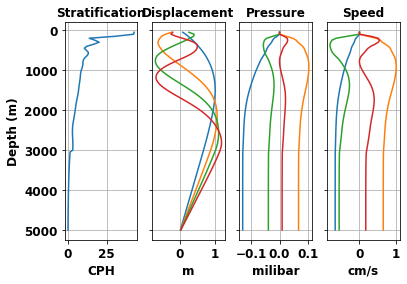

In [90]:
%autoreload
plots = mode_plot(iwi.iwmodes[0],4)

In [91]:
wavenumbers = 1e-3/iwi.ps.hwvn.unique()
ares  = np.arctan(2*wavenumbers/(24*12.42))
#print("Wave numbers",wavenumbers)
#print("Angular Res.",180*ares/np.pi)


/home/jpdef/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """Entry point for launching an IPython kernel.


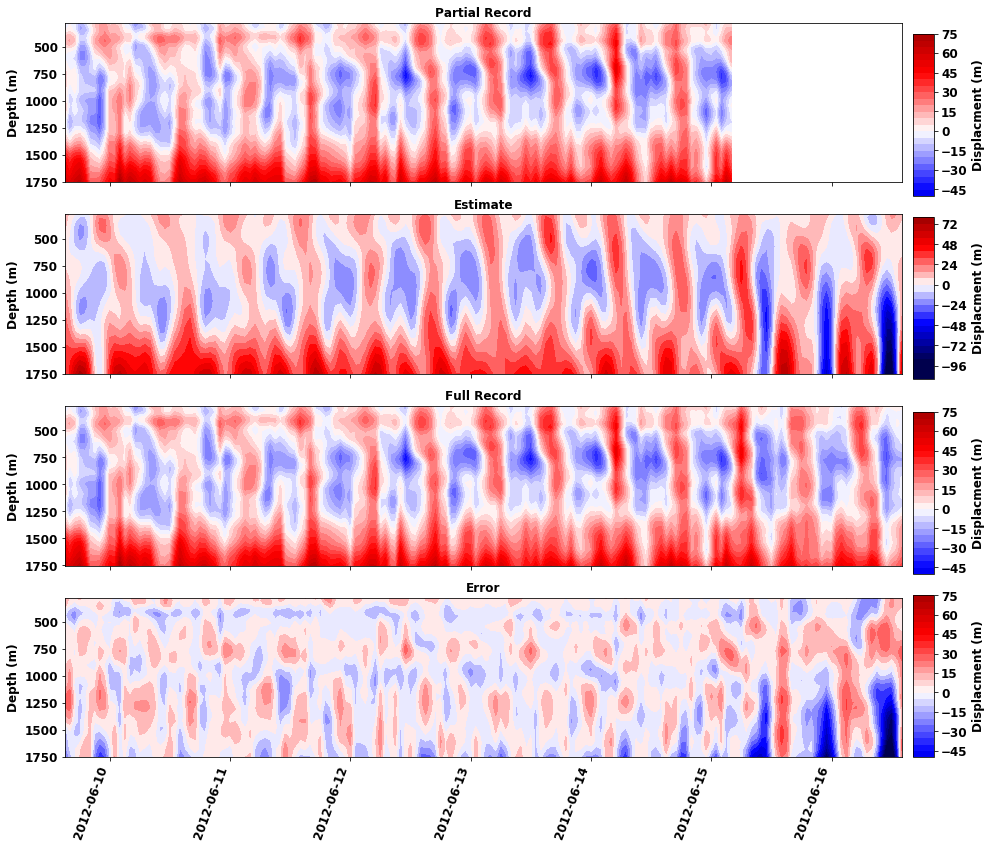

In [95]:
%autoreload
import iw_plots as iwp
"""
Plotting Forecasts
"""
xu = cube['x'].unique()
yu = cube['y'].unique()

line = cube[(cube["x"]==xu[2]) & (cube["y"]==yu[2])]
f, ax = plt.subplots(4,1,sharex=True)
cnorm = (-90,0,90)
p1 = iwp.plot_dataframe_slice(line[line['time'] < split_time],'date','z','dz',ax[0],cnorm=(cnorm),invert=True)
p2 = iwp.plot_dataframe_slice(line,'date','z','dz_hat',ax[1],cnorm=(cnorm),invert=True)
p3 = iwp.plot_dataframe_slice(line,'date','z','dz',ax[2],cnorm=(cnorm),invert=True)
p4 = iwp.plot_dataframe_slice(line,'date','z','err',ax[3],cnorm=(cnorm),invert=True)
ax[0].set_title('Partial Record')
ax[1].set_title('Estimate')
ax[2].set_title('Full Record')
ax[3].set_title('Error')

for a in ax:
    a.set_ylabel('Depth (m)')
f.autofmt_xdate(rotation=70)
cax1 = f.add_axes([.91, 0.72, 0.02, 0.15])
cax2 = f.add_axes([.91, 0.55, 0.02, 0.15])
cax3 = f.add_axes([.91, 0.37, 0.02, 0.15])
cax4 = f.add_axes([.91, 0.2, 0.02, 0.15])
f.colorbar(p1,cax=cax1,label="Displacment (m)")
f.colorbar(p2,cax=cax2,label="Displacment (m)")
f.colorbar(p3,cax=cax3,label="Displacment (m)")
f.colorbar(p3,cax=cax4,label="Displacment (m)")
f.set_size_inches(15,15)

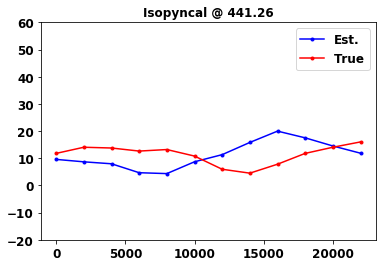

In [93]:
import matplotlib.animation as animation
from IPython.display import HTML
"""
Animation of 500 meter depth displacment
"""
zu = np.unique(cube['z'])
du = np.unique(cube['time'])
lu = np.unique(cube['y'])


fig,ax = plt.subplots()
di = 6
top = cube[(cube["time"]==du[0]) & (cube["z"]==zu[di]) & (cube["y"]==lu[2])]
p1, = ax.plot(top['x'].values,top['dz_hat'].values,'b.-',label='Est.')
p2, = ax.plot(top['x'].values,top['dz'].values,'r.-',label='True')
ax.legend()
ax.set_title('Isopyncal @ %.2f' % zu[di])
ax.set_ylim(-20,60)

def update(frame):
    top = cube[(cube["time"]==du[frame]) & (cube["z"]==zu[di]) & (cube["y"]==lu[2])]
    p1.set_data(top['x'].values,top['dz_hat'].values)
    p2.set_data(top['x'].values,top['dz'].values)
    return p,
    

#Compile Animation
ani = animation.FuncAnimation(fig, update,frames=np.arange(0,40,1),blit=False)

HTML(ani.to_html5_video())
##ani.save("foo.mp4")


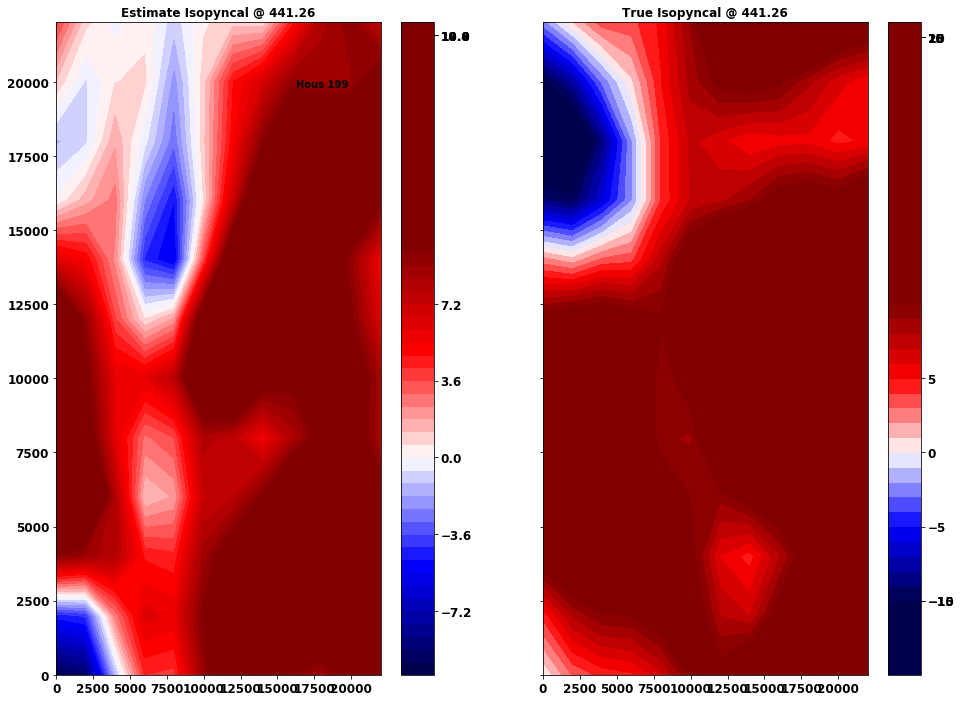

In [94]:
"""
Animation of 500 meter depth displacment
"""
zu = np.unique(cube['z'])
du = np.unique(cube['time'])
lu = np.unique(cube['y'])
di = 6
layer = cube[(cube["time"]==du[0]) & (cube["z"]==zu[di])]


fig,ax = plt.subplots(1,2,sharey=True)
p1 = plot_dataframe_slice(layer,'x','y','dz_hat',ax[0],cmap='seismic',levels=50,cnorm=(-10,0,10))
p2  = plot_dataframe_slice(layer,'x','y','dz',ax[1],cmap='seismic',levels=50,cnorm=(-10,0,10))

#ax.legend()
ax[0].set_title('Estimate Isopyncal @ %.2f' % zu[di])
ax[1].set_title('True Isopyncal @ %.2f' % zu[di])
timelabel = ax[0].text(0.9,0.9, "", transform=ax[0].transAxes, ha="right")
#ax.set_ylim(-20,20)
fig.colorbar(p1,ax=ax[0])
fig.colorbar(p2,ax=ax[1])
fig.set_size_inches(16,12)
def update(frame):
    layer = cube[(cube["time"]==du[frame]) & (cube["z"]==zu[di]) ]
    #p1.set_data(top['x'].values,top['dz_hat'].values)
    #p2.set_data(top['x'].values,top['dz'].values)
    p1  = plot_dataframe_slice(layer,'x','y','dz_hat',ax[0],cmap='seismic',levels=50,cnorm=(-10,0,10))
    p2  = plot_dataframe_slice(layer,'x','y','dz',ax[1],cmap='seismic',levels=50,cnorm=(-10,0,10))
    timelabel.set_text("Hous %d" % ( du[frame]/3600 ) )
    return p1, p2
    

#Compile Animation
ani = animation.FuncAnimation(fig, update,frames=np.arange(0,10,1),interval=500,blit=False)

HTML(ani.to_html5_video())
##ani.save("foo.mp4")